# Egecentric Stochastic Block Model

This notebook summarizes the Python classes which help us deal with the parameters of an SBM of the type we have been defining, to be learnt from egocentric social surveys such as Understanding Society. 

## `EgocentricSBM` Class

`EgocentricSBM` stores the SBM's parameters. It consists of $d$ dimensions, each of which have $k_i$ number of blocks or communities (that is, of shape $(k_1,k_2,\dots k_d)$). Corresponding to every $j$th community in dimension $i$ we have the parameters

1. $\pi_{ij}$, which refers to the proportion of population belonging to $j$ (along $i$). 
2. $\rho_{ij}$, which refers to the proportion of friends of people in community $j$ (along $i$) from within community $j$ (along $i$).
3. $\omega_{ij}$, which refers to the mean (out)degree of population belonging to $j$ (along $i$).

Clearly, these parameters must respect the following constraints:

1. $0<\pi_{ij}<1$, $\sum_j\pi_{ij}=1$
2. $0\le\rho_{ij}\le1$
3. $0\le\omega_{ij}$, $\sum_j\omega_{ij}\pi_{ij}=\omega$, where $\omega$ is the mean (out)degree of the entire population

A community $j$ is said to be homophilous if $\pi_{ij}<\rho_{ij}$, heterophilous if $\pi_{ij}>\rho_{ij}$ and ambiphilous if $\pi_{ij}=\rho_{ij}$.

Under a "directed" SBM, the "affinity" from community $u$ to $v$ along dimension $i$ is given by $\psi_{uu}^i = \omega_{iu}\frac{\rho_{iu}}{\pi_{iu}}$, $\psi_{vv}^i = \omega_{iu}\frac{1-\rho_{iu}}{1-\pi_{iu}}$. Below, we write some key properties of the members of this SBM:

1. The mean preference of a community to itself, the mean "homophily", along dimension $i$ is given by $\sum_{j}\frac{\rho_{ij}}{\pi_{ij}}\pi_{ij}^2 = \sum_{j}\rho_{ij}\pi_{ij}$.
2. Similarly, the mean preference of a communnity to any other community, mean "heterophily" is given by $\sum_{j}\frac{1-\rho_{ij}}{1-\pi_{ij}}(1-\pi_{ij})\pi_{ij} = \sum_{j}(1-\rho_{ij})\pi_{ij} = 1-\sum_{j}\rho_{ij}\pi_{ij}$.
3. The mean affinity of a community to itself, the mean "homoffinity", is given by $\sum_{j}\omega_{ij}\rho_{ij}\pi_{ij}$.
4. The mean "heteroffinity" is given by $\sum_{j}\omega_{ij}(1-\rho_{ij})\pi_{ij} = \omega - \sum_{j}\omega_{ij}\rho_{ij}\pi_{ij}$, where $\omega$ refers to the mean (out)degree, which is the same across any dimenison $i$.

Let's demonstrate these ideas below, by creating an `EgocentricSBM` of shape `(2,4)`.

In [1]:
from egosbm import EgocentricSBM

In [2]:
ego_sbm = EgocentricSBM([2,4])
print(ego_sbm)

name:	egocentric_sbm
ndim:	2
shape:	(2, 4)
|dims|	|blocks|
0	('0', '1')
1	('0', '1', '2', '3')
pi:	((0.5, 0.5), (0.25, 0.25, 0.25, 0.25))
rho:	((0.5, 0.5), (0.25, 0.25, 0.25, 0.25))
omega:	((1.0, 1.0), (1.0, 1.0, 1.0, 1.0))


The SBM is initialized with the least-informative assumptions: equi-proportined population, ambiphily, and mean-degree of 1. We can use some class methods to initialize a more interesting SBM.

In [3]:
ego_sbm.set_pi()
ego_sbm.set_omega(5)
ego_sbm.set_rho()

In [4]:
print(ego_sbm)

name:	egocentric_sbm
ndim:	2
shape:	(2, 4)
|dims|	|blocks|
0	('0', '1')
1	('0', '1', '2', '3')
pi:	((0.6919465773017894, 0.3080534226982105), (0.2003292566478986, 0.36827570566610723, 0.29187281312372537, 0.13952222456226884))
rho:	((0.30280939601589046, 0.4601433578482155), (0.4449803321951378, 0.8314477547463477, 0.34341526307917536, 0.28805410106089235))
omega:	((5.116386065247539, 4.738574761519359), (2.0619696998269044, 4.015366653010031, 4.900658072833957, 12.025297779949163))


This SBM looks more realistic, and obeys a mean-degree of $5$. We can confirm that and other properties by using the following definitions and methods.

In [5]:
print('mean degree', ego_sbm.mean_omega())
print('mean homophily', ego_sbm.mean_homophily())
print('mean heterophily', ego_sbm.mean_heterophily())
print('mean homoffinity', ego_sbm.mean_homoffinity())
print('mean heteroffinity', ego_sbm.mean_heteroffinity())

mean degree [5.0, 5.0]
mean homophily [0.3512766614650078, 0.5357681156541421]
mean heterophily [0.6487233385349922, 0.46423188434585794]
mean homoffinity [1.7437127408964992, 2.3878292334527798]
mean heteroffinity [3.2562872591035017, 2.6121707665472202]


In [6]:
print(ego_sbm.ishomophilous())

((False, True), (True, True, True, True))


Clearly, not all communities are homophilous, which is quite unlikely for a social network. Let us enforce homophily by setting a random $\rho$ such that $\pi<\rho<=1$.

In [7]:
ego_sbm.enforce_homophily()
print(ego_sbm.ishomophilous())

((True, True), (True, True, True, True))


## `StochasticBlockModel` Class

This class takes parameters from an `EgocentricSBM` and turns it into an appropriate SBM with full block matrix $\Psi \propto \bigotimes_i\Psi^i$. Recall that we have 3 model types:

1. The "Full" (`full`) SBM Model uses block matrices $\Psi^i$s which have different entires for different communities along a given dimension $i$, which means a model with $3*\Pi_i^dk_i$ number of parameters. More precisely,
    1. $\Psi_{uu}^i = \omega_{iu}\frac{\rho_{iu}}{\pi_{iu}}$
    2. $\Psi_{uv}^i = \omega_{iu}\frac{1-\rho_{iu}}{1-\pi_{iu}}$
    3. $\Psi = \frac{1}{\omega^{d-1}}\bigotimes_i\Psi^i$
2. The "Planted partition" (`pp`) SBM Model uses block matrices $\Psi^i$s which have same entries for different communities along a given dimension $i$, which means a model with $1+2d$ number of parameters. More precisely, we can use the model's mean properties such that the mean affinity of the model is preserved.
    1. $\Psi_{uu}^i = \omega\frac{\sum_u\rho_{iu}\pi_{iu}}{\sum_u\pi_{iu}^2}$
    2. $\Psi_{uv}^i = \omega\frac{1-\sum_u\rho_{iu}\pi_{iu}}{1-\sum_u\pi_{iu}^2}$
    3. $\Psi = \frac{1}{\omega^{d-1}}\bigotimes_i\Psi^i$
3. While the `pp` model preserves mean affinity, it doesn't preserve the mean homoffinity and mean heteroffinity separately. This is because we essentially have two degrees of freedom, one of which goes in keeping the mean degree "separate" from the homophily parameter. We can overcome this problem by marginalizing over $\omega_{iu}$, which means we absorb it, but this let's us preserve both mean homoffinity and mean heteroffinity of the network along that dimension $i$. We call this the "Planted partition collapsed" (`ppcollapsed`) SBM Model, which leads to a model with $2d$ number of parameters. More precisely,
    1. $\Psi_{uu}^i = \frac{\sum_u\omega_{iu}\rho_{iu}\pi_{iu}}{\sum_u\pi_{iu}^2}$
    2. $\Psi_{uv}^i = \frac{\omega-\sum_u\omega_{iu}\rho_{iu}\pi_{iu}}{1-\sum_u\pi_{iu}^2}$
    3. $\Psi = \frac{1}{\omega^{d-1}}\bigotimes_i\Psi^i$
    
### Notes

1. If every community along a dimension $i$ has the same mean degree, then `pp`==`ppcollapsed`.
2. If every community along a dimension $i$ has the same level of homophily or heterophily ($\rho_{ij}/\pi_{ij}$) as well, then `full`==`pp`==`ppcollapsed`.
3. The planted partition models have a symmetric block matrix, while the full model can be chosen to be directed or undirected, which renders the concept of in/out-(hetero)affinities.

In [8]:
model_full = ego_sbm.get_model('full')
model_pp = ego_sbm.get_model('pp')
model_ppc = ego_sbm.get_model('ppcollapsed')

In [9]:
print('full\n', model_full.params)
print('planted partition\n', model_pp.params)
print('planted partition collapsed\n', model_ppc.params)

full
 (((5.116386065247539, 1.2221329616631744, 0.5010471197415589), (4.738574761519359, 3.18670618205161, 0.02648217953025991)), ((2.0619696998269044, 1.7234224802280058, 0.8187720522336968), (4.015366653010031, 1.5896270390792944, 0.6562656908332005), (4.900658072833957, 2.108053490759078, 0.5432872859096668), (12.025297779949163, 4.778954824965725, 0.38726112544705493)))
planted partition
 (5.0, ((1.5471044843954591, 0.26376464963590956), (1.9876762246394497, 0.6151125663803649)))
planted partition collapsed
 ((7.716427522352061, 1.3445191445151197), (10.723748289433185, 2.769513191826687))


In [10]:
print('homoffinity', model_full.homoffinity())
print('out heteroffinity', model_full.heteroffinity_out())
print('in heteroffinity', model_full.heteroffinity_in())
print('heteroffinity', model_full.heteroffinity(directed=False))
print('affinity', model_full.affinity(directed=False))
print('mean homoffinity', model_full.mean_homoffinity())
print('mean heteroffinity', model_full.mean_heteroffinity())
print('mean affinity', model_full.mean_affinity())

homoffinity [0.61603124 2.03412598 2.60923983 6.93835446 0.66231441 2.18695232
 2.80527516 7.4596414 ]
out heteroffinity [1.49393537 2.07470722 2.40549191 5.36685874 1.2918451  1.6184707
 1.83915177 3.93691311]
in heteroffinity [2.09851262 1.55918791 1.73314204 1.88301097 3.33337879 3.10225301
 3.58652639 5.52503359]
heteroffinity [1.79622399 1.81694757 2.06931697 3.62493486 2.31261194 2.36036185
 2.71283908 4.73097335]
affinity [ 2.41225524  3.85107354  4.6785568  10.56328931  2.97492636  4.54731417
  5.51811424 12.19061476]
mean homoffinity 2.6623743221572806
mean heteroffinity 2.3376256778427202
mean affinity 5.0


C:\Users\lenovo\Desktop\phd\dat\egosbm.py:606: RuntimeWarning: symmetrising the stochastic block matrix
  warn('symmetrising the stochastic block matrix', RuntimeWarning)


In [11]:
print('homoffinity', model_pp.homoffinity())
print('heteroffinity', model_pp.heteroffinity())
print('affinity', model_pp.affinity())
print('mean homoffinity', model_pp.mean_homoffinity())
print('mean heteroffinity', model_pp.mean_heteroffinity())
print('mean affinity', model_pp.mean_affinity())

homoffinity [2.13133755 3.91814883 3.10528526 1.48440104 0.9488678  1.7443531
 1.38246764 0.66085278]
heteroffinity [2.99447145 2.53517095 2.74411783 3.16076672 1.98439005 1.94857632
 1.96486885 1.99735684]
affinity [5.12580901 6.45331978 5.84940309 4.64516776 2.93325785 3.69292942
 3.34733649 2.65820962]
mean homoffinity 2.4734977501710977
mean heteroffinity 2.526502249828902
mean affinity 4.999999999999999


In [12]:
print('homoffinity', model_ppc.homoffinity())
print('heteroffinity', model_ppc.heteroffinity())
print('affinity', model_ppc.affinity())
print('mean homoffinity', model_ppc.mean_homoffinity())
print('mean heteroffinity', model_ppc.mean_heteroffinity())
print('mean affinity', model_ppc.mean_affinity())

homoffinity [2.29408673 4.21733912 3.3424052  1.59775007 1.02132346 1.8775521
 1.48803303 0.71131558]
heteroffinity [2.72642775 2.34038937 2.51600754 2.86619759 1.86470642 1.8921413
 1.87966051 1.85477329]
affinity [5.02051449 6.55772849 5.85841274 4.46394767 2.88602987 3.7696934
 3.36769354 2.56608887]
mean homoffinity 2.66237432215728
mean heteroffinity 2.3376256778427194
mean affinity 5.0


### Eigenvalues

We noted earlier that the eigenvalues of the expected adjacency matrix generated from the SBM would be the same as the eigenvalues of $\Pi\Psi$, where $\Pi$ is a diagonal matrix representing distribution of people in the "testing" population. In particular, if this distribution is uniform, and if the models we consider are the planted partition model, then these eigenvalues can be written in closed form. To see that in practice, let us find the eigenvalues of $\Pi\Psi$ computationally, and theoretically. First for the default testing=training population distribution, and then for an assumed uniform testing distribution.

In [13]:
print('pp\n', model_pp.eigvals_pipsi())
print('ppc\n', model_ppc.eigvals_pipsi())

pp
 [5.579133976853608, 2.4479707343183783, 2.3070252478063797, 1.7006835515572682, 1.1498983234249547, 1.0122593064432155, 0.7032489107179205, 0.47549395220791657]
ppc
 [5.6186374431450865, 2.8212818090140863, 2.315919906052594, 1.9547521038582532, 1.3246157546987827, 1.162890962123092, 0.8057201331341767, 0.5459871766455583]


In [98]:
print('pp uni computational\n', model_pp.eigvals_pipsi('uni'), '\npp uni theoretical\n', model_pp.eigvals_pipsi_theoretical())
print('ppc uni computational\n', model_ppc.eigvals_pipsi('uni'), '\nppc uni theoretical\n', model_ppc.eigvals_pipsi_theoretical())

pp uni computational
 [4.338179128054155, 3.0744121597347345, 1.553458227021598, 1.5534582270215975, 1.5534582270215966, 1.1009160114919856, 1.1009160114919851, 1.100916011491985] 
pp uni theoretical
 [4.338179128054159, 3.074412159734736, 1.5534582270215977, 1.5534582270215977, 1.5534582270215977, 1.1009160114919854, 1.1009160114919854, 1.1009160114919854]
ppc uni computational
 [4.311263632311059, 3.031799862396125, 1.8018224998783894, 1.8018224998783892, 1.801822499878388, 1.2670914314430872, 1.2670914314430868, 1.2670914314430866] 
ppc uni theoretical
 [4.311263632311059, 3.031799862396127, 1.8018224998783887, 1.8018224998783887, 1.8018224998783887, 1.2670914314430872, 1.2670914314430872, 1.2670914314430872]


### Social Access Statistic

There are multiple ways to adjudge people's social access or [isolation](https://link.springer.com/article/10.1007/s10964-018-0860-3). We enlist come built-ins here:

1. "Disengagement", which is a measure of out-degree, can be measured by using total "out-affinity" of a community.
2. "Unliked", which is a measure of in-degree, can be measured by using total "in-affinity" of a community.
3. "Outside orientation", which is a measure of out-of-community engagement, can be measured using either the difference of heterophily and homophily, or log-ratio of heterophily and homophily.

More precisely, we elaborate on the latter of the third one, which is closest to the social isolation statistic defined by Till. Say $\Psi$ represents the full matrix where we can choose to take the negative-log-ratio of off-diagonal elements with the diagonals, which gives us the matrix $\mathcal{L}$. Let $\boldsymbol{\pi}$ represent the column-vector of community probabilities (i.e. $\boldsymbol{\pi} = \mathrm{diag}(\Pi)$.

1. The pairwise affinity between two individuals of communities $u$ and $v$ is given by $\mathcal{L}_{uv}$. This is calculated by `sas_individual_pw()`.
2. The overall out/in-affinity experienced by an individual of community $j$ is given by $[\mathcal{L}\boldsymbol{\pi}]_j$. This is calculated by `sas_individual_out()`, `sas_individual_in()` and `sas_individual()`.
3. The global affinity of a society is a given by $\boldsymbol{\pi}^T\mathcal{L}\boldsymbol{\pi}$. This is calculated by `sas_global()`.

The lower the SAS, the lower the isolation/higher the social access.

#### Note
1. Even thought the SBM is defined assuming independent Blau dimensions, the testing population need not assume a testing distribution that factorizes. That is, a testing population of 50/50 males/females and 50/50 employed/unemployed will be treated differently from 50/50 employed-males/unemployed-females.
2. While the SAS we obtain need not be a metric, we can use built-ins to define a metric from this statistic, if we need to.
    1. SAS will respect positivity for a homophilous society.
    2. We can choose to set identicals as indiscernible.
    3. We can enforce symmetry by symmetrising the block matrix (this matters only if a full SBM is used).
    4. We use shortest-path graph algorithm to make the SAS follow the triangle inequality.
3. For planted partition models, we can express the $\Psi^i/\mathcal{L}^i$ matrix with diagonal entries $p$ and off-diagonal entries $q$.
    1. We can write the mean affinity experienced by individuals simply as: $p\sum_j\pi_{ij}+q\left(\sum_j1-\pi_{ij}\right) = p+q(k_i-1)$.
    2. We can write the mean affinity experienced by communities simply as: $p\sum_j\pi_{ij}^2+q\sum_j(1-\pi_{ij})\pi_{ij} = p\delta+q(1-\delta)$, where $\delta=\sum_j\pi_{ij}^2$ is the deviation in $\pi$. Now $\delta$ is minimized for a uniform distribution ($1/k_i$), and maximized if there is any one big majority community ($\approx 1$). It can be seen as imposing a linear combination between $p$ and $q$.

In [15]:
print('sas indivl pw\n', model_full.sas_individual_pw())
print('sas indivl out\n', model_full.sas_individual_out())
print('sas indivl in\n', model_full.sas_individual_in())
print('global sas', model_full.sas_global())

sas indivl pw
 [[-0.          1.07374264  1.07374264  1.07374264  1.28638306  2.36012571
   2.36012571  2.36012571]
 [ 1.2763364  -0.          1.2763364   1.2763364   2.56271946  1.28638306
   2.56271946  2.56271946]
 [ 1.95612428  1.95612428 -0.          1.95612428  3.24250735  3.24250735
   1.28638306  3.24250735]
 [ 3.62531654  3.62531654  3.62531654 -0.          4.9116996   4.9116996
   4.9116996   1.28638306]
 [ 6.91090033  7.98464298  7.98464298  7.98464298 -0.          1.07374264
   1.07374264  1.07374264]
 [ 8.18723673  6.91090033  8.18723673  8.18723673  1.2763364  -0.
   1.2763364   1.2763364 ]
 [ 8.86702462  8.86702462  6.91090033  8.86702462  1.95612428  1.95612428
  -0.          1.95612428]
 [10.53621687 10.53621687 10.53621687  6.91090033  3.62531654  3.62531654
   3.62531654 -0.        ]]
sas indivl out
 [1.25491528 1.20256742 1.78145949 3.51577902 5.64061441 5.58826654
 6.16715862 7.90147814]
sas indivl in
 [3.67572192 3.42078029 3.31988448 3.38501175 2.43690377 2.18196

In [16]:
print('sas indivl pw\n', model_full.sas_individual_pw(metric_type='metric'))
print('sas indivl out\n', model_full.sas_individual_out(metric_type='metric'))
print('sas indivl in\n', model_full.sas_individual_in(metric_type='metric'))
print('global sas', model_full.sas_global(metric_type='metric'))

sas indivl pw
 [[0.         1.17503952 1.51493346 2.34952959 4.0986417  5.27368122
  5.61357516 6.44817129]
 [1.17503952 0.         1.61623034 2.45082647 5.27368122 4.0986417
  5.71487204 6.54946817]
 [1.51493346 1.61623034 0.         2.79072041 5.61357516 5.71487204
  4.0986417  6.88936211]
 [2.34952959 2.45082647 2.79072041 0.         6.44817129 6.54946817
  6.88936211 4.0986417 ]
 [4.0986417  5.27368122 5.61357516 6.44817129 0.         1.17503952
  1.51493346 2.34952959]
 [5.27368122 4.0986417  5.71487204 6.54946817 1.17503952 0.
  1.61623034 2.45082647]
 [5.61357516 5.71487204 4.0986417  6.88936211 1.51493346 1.61623034
  0.         2.79072041]
 [6.44817129 6.54946817 6.88936211 4.0986417  2.34952959 2.45082647
  2.79072041 0.        ]]
sas indivl out
 [2.4653186  2.31167386 2.55067199 3.45039538 4.03875909 3.88511435
 4.12411248 5.02383588]
sas indivl in
 [2.4653186  2.31167386 2.55067199 3.45039538 4.03875909 3.88511435
 4.12411248 5.02383588]
global sas 3.0557911396573836


In [102]:
print('training pi', model_full.get_pi())
print('indivl sas full trn-pi', model_full.sas_individual_out())
print('indivl sas full uni-pi', model_full.sas_individual_out(pi='uni'))
print('indivl sas pp trn-pi', model_pp.sas_individual())
print('indivl sas pp uni-pi', model_pp.sas_individual(pi='uni'))
print('indivl sas ppc trn-pi', model_ppc.sas_individual())
print('indivl sas ppc uni-pi', model_ppc.sas_individual(pi='uni'))

training pi [0.13861714 0.25482711 0.20196039 0.09654193 0.06171211 0.11344859
 0.08991242 0.0429803 ]
indivl sas full trn-pi [1.25491528 1.20256742 1.78145949 3.51577902 5.64061441 5.58826654
 6.16715862 7.90147814]
indivl sas full uni-pi [1.44849851 1.60044383 2.11028474 3.36217893 4.26075715 4.41270247
 4.92254338 6.17443757]
indivl sas pp trn-pi [2.13939976 1.85520743 1.98449338 2.24229501 3.1191901  2.83499777
 2.96428372 3.22208536]
indivl sas pp uni-pi [2.54524407 2.54524407 2.54524407 2.54524407 2.54524407 2.54524407
 2.54524407 2.54524407]
indivl sas ppc trn-pi [2.33839513 2.01037809 2.15960096 2.45715765 3.30612942 2.97811238
 3.12733524 3.42489193]
indivl sas ppc uni-pi [2.7252501 2.7252501 2.7252501 2.7252501 2.7252501 2.7252501 2.7252501
 2.7252501]


In [99]:
print('global sas full trn-pi', model_full.sas_global())
print('global sas full uni-pi', model_full.sas_global(pi='uni'))
print('global sas pp trn-pi', model_pp.sas_global())
print('global sas pp uni-pi', model_pp.sas_global(pi='uni'))
print('global sas ppc trn-pi', model_ppc.sas_global())
print('global sas ppc uni-pi', model_ppc.sas_global(pi='uni'))

global sas full trn-pi 3.055791139657384
global sas full uni-pi 3.536480824069606
global sas pp trn-pi 2.305709609191399
global sas pp uni-pi 2.5452440659513123
global sas ppc trn-pi 2.4800931346277664
global sas ppc uni-pi 2.725250099077716


It's easy to see that although a uniform population increases global isolation, it decreases isolation of minorities. Thus, if we would like to be mindful of the isolation of individuals, irrespective of whether they are in a majority or minority class, we should analyse things at the level of individuals. If we would like to minimize overall isolation or access (which would naturally cater more to a majority), we should look at the global SAS.

## `NetworkData` Class

Once we have an SBM model, we can probabilistically generate data from it. The `NetworkData` class allows us to do that. Say we want to obtain a network of $n$ people, then we can generate their community memberships $Z\in\{0,1\}^{n\times \Pi k_i}$ according to $\mathrm{Categorical}(\pi)$ (which can be the same as the training population, by default), and edges between them according to $\mathrm{Binomial}\left(\frac{1}{n-1}Z\Psi Z^T\right)$

In [81]:
data_full = model_full.generate_data(n=1000)
data_full_uni = model_full.generate_data(n=1000, pi='uni')
data_ppc = model_ppc.generate_data(n=1000)
data_ppc_uni = model_ppc.generate_data(n=1000, pi='uni')

C:\Users\lenovo\Desktop\phd\dat\egosbm.py:629: RuntimeWarning: generating an undirected network from a directed SBM
  warn('generating an undirected network from a directed SBM', RuntimeWarning)


In [82]:
print('mean degree full trn', data_full.mean_degree())
print('mean degree full uni', data_full_uni.mean_degree())

mean degree full trn 4.584
mean degree full uni 8.126


Clearly, the mean degree of the network is close to $5$, which was the mean omega value we set in the model. Of course, the mean degree changes when the testing population is enforced to be uniform. This can be seen if we find mean affinity with a uniform distribution, which should coincide with mean degree of `data_full_uni`.

In [83]:
print('mean affinity full trn', model_full.mean_affinity())
print('mean affinity full uni', model_full.mean_affinity(pi='uni'))

mean affinity full trn 5.0
mean affinity full uni 8.464743445458776


Let us sort the data generated by community ID, and then visualize the adjacency matrix.

In [85]:
data_full.sort()
data_full_uni.sort()
data_ppc.sort()
data_ppc_uni.sort()

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

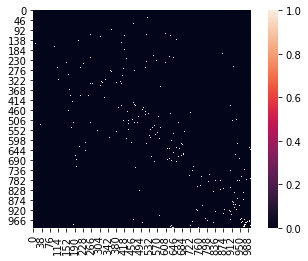

In [86]:
plot = sns.heatmap(data_full.adj, square=True)

The block-structure of the communities is quite apparent. In fact, we can note the fractal block-structure, due to the Kronecker structure of the SBM model. Especially when the population is made to follow a uniform distribution.

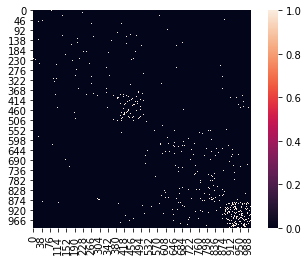

In [87]:
plot = sns.heatmap(data_full_uni.adj, square=True)

For the planted partition model, we do see a block structure, but it's not as rich as the full model.

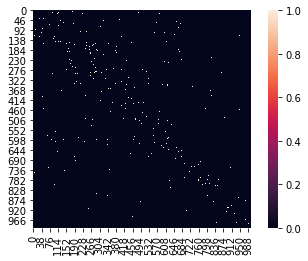

In [88]:
plot = sns.heatmap(data_ppc.adj, square=True)

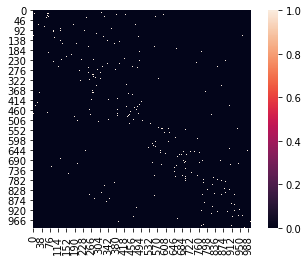

In [89]:
plot = sns.heatmap(data_ppc_uni.adj, square=True)

### Eigenvalues

We can easily compute the eigenvalues of the adjacency matrix. Since we have generated an undirected graph, it will have real eigenvalues. We would like to test how close the eigenspectrum of adjacency matrix is to the eigenspectrum of the expected adjacency matrix (= eigenspectrum of $\Pi\Psi$).

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi full
 [7.974115477736083, 6.949546443383651, 3.3754254670111066, 2.9417276580290386, 1.6941435734597903, 1.4764683905557592, 0.48116562318788203, 0.4193421646124936]
eigs adj top-10 [9.059336398205724, 6.927339587427406, 5.717262396465161, 5.256082382726751, 5.189762109192868, 5.027200977341099, 4.915350046836964, 4.844982350395266, 4.746871126286123, 4.709717846640803]


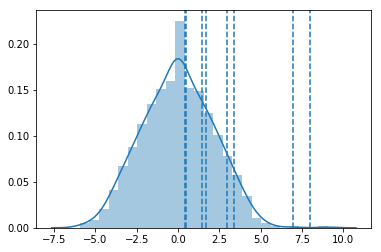

In [94]:
adje = data_full.eigvals()
plot = sns.distplot(adje)
eigs = model_full.eigvals_pipsi()
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi full\n', eigs)
print('eigs adj top-10\n', adje[:10])

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi full uni
 [22.012913086127924, 9.040801552518083, 4.515694823001261, 1.998371375020705, 1.8546159977442902, 0.8895184279109707, 0.820740033775004, 0.3653291844012588]
eigs adj top-10
 [22.200245502786345, 10.070787464806576, 8.325784307080282, 8.046957514902202, 7.824046456234791, 7.715417895418247, 7.584924003048472, 7.403544483498261, 7.349618836904194, 7.293704363605583]


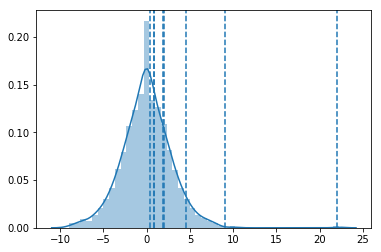

In [95]:
adje = data_full_uni.eigvals()
plot = sns.distplot(adje)
eigs = model_full.eigvals_pipsi(pi='uni')
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi full uni\n', eigs)
print('eigs adj top-10\n', adje[:10])

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi ppc
 [5.6186374431450865, 2.8212818090140863, 2.315919906052594, 1.9547521038582532, 1.3246157546987827, 1.162890962123092, 0.8057201331341767, 0.5459871766455583]
eigs adj top-10
 [6.589619716606132, 4.985336686745687, 4.894831189596206, 4.856890103165404, 4.802088572660106, 4.763487541451036, 4.71260646960192, 4.668032414135106, 4.644298970013113, 4.5779292266246525]


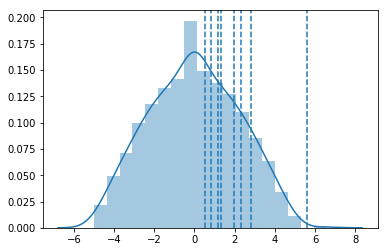

In [96]:
adje = data_ppc.eigvals()
plot = sns.distplot(adje)
eigs = model_ppc.eigvals_pipsi()
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi ppc\n', eigs)
print('eigs adj top-10\n', adje[:10])

In particular, for the planted partition model with a uniform testing population, the eigenvalues of the expected adjacency matrix can be written in closed-form.

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


eigs pipsi ppc uni (closed-form)
 [4.311263632311059, 3.031799862396125, 1.8018224998783894, 1.8018224998783892, 1.801822499878388, 1.2670914314430872, 1.2670914314430868, 1.2670914314430866]
eigs adj top-10
 [5.535701599695652, 4.749246649152036, 4.518301197668974, 4.436837875600386, 4.365047796651121, 4.31777454482286, 4.295853440009558, 4.238736416034244, 4.202067317730374, 4.180384055711008]


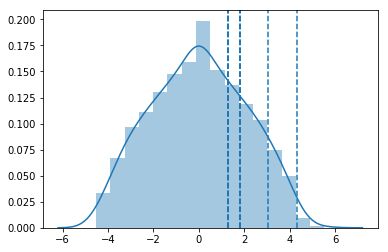

In [103]:
adje = data_ppc_uni.eigvals()
plot = sns.distplot(adje)
eigs = model_ppc.eigvals_pipsi(pi='uni')
[plt.gca().axvline(i, ls='--') for i in eigs]
print('eigs pipsi ppc uni (closed-form)\n', eigs)
print('eigs adj top-10\n', adje[:10])

We see a fair agreement of top eigenvalues.